In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, precision_recall_curve, auc
import seaborn as sns
import numpy as np

In [2]:

df = pd.read_csv('creditcard.csv')


The columns are features: due to privacity we don't know the columns name but we have time and amount: Time is the difference between the each transaction and the first transaction dataset and Amount is the transaction amount

# EDA

## Ver a distribuição das classes
Vamos ver como as classes estão distribuídas, isso pode nos ajudar a entender um pouco melhor os dados, como há no geral poucos dados fraudulentos é esperado que hajam bem mais registros de dados não fraudulentos do que de fraudulentos

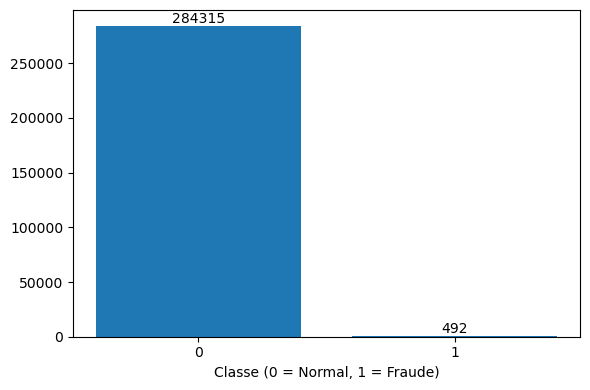

Percentual de dados fraudulentos: 0.173%
Percentual de dados não fraudulentos: 99.827%


In [3]:
class_count = df['Class'].value_counts()

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(class_count.index.astype(str), class_count.values)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x()+bar.get_width()/2,
        height, 
        str(height),
        ha='center', 
        va='bottom'
    )
plt.xlabel('Classe (0 = Normal, 1 = Fraude)')
plt.tight_layout()
plt.show()
print(f"Percentual de dados fraudulentos: {round(100*class_count[1]/df.shape[0], 3)}%")
print(f"Percentual de dados não fraudulentos: {round(100*class_count[0]/df.shape[0], 3)}%")


## Estatística básica das variáveis
A ideia é olharmos para os números para entendermos melhor os dados

### Como as quantidades se relacionam com os dados fraudados

Podemos ver que a média dos dados fraudados ela é maior que a média dos dados normais mas a mediana não é, oque quer dizer que a maioria das transações fraudulentas, tem valores inferiores a media. E outra parte (75%) tem valores superiores, isso pode nos ajudar no futuro

In [4]:
fraude = df.where(df['Class'] == 1).describe()['Amount']
normal = df.where(df['Class'] == 0).describe()['Amount']
pd.DataFrame({'Normal': normal, 'Fraude': fraude})

,Normal,Fraude
count,284315.000000,492.000000
mean,88.291022,122.211321
std,250.105092,256.683288
min,0.000000,0.000000
25%,5.650000,1.000000
50%,22.000000,9.250000
75%,77.050000,105.890000
max,25691.160000,2125.870000


### Correlação entre as variáveis e os dados fraudados

Interessante notar que amount não está entre as principais variáveis que se relacionam com a classe. As principais são: V17, V14, V12 ,V10, V16, V3 e V7

In [5]:
correlations = df.corr(numeric_only=True)
class_correlations = correlations['Class'].drop('Class')
sorted_class_correlations = class_correlations.sort_values(key=abs, ascending=False)
print(sorted_class_correlations)

V17      -0.326481
V14      -0.302544
V12      -0.260593
V10      -0.216883
V16      -0.196539
V3       -0.192961
V7       -0.187257
V11       0.154876
V4        0.133447
V18      -0.111485
V1       -0.101347
V9       -0.097733
V5       -0.094974
V2        0.091289
V6       -0.043643
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
Time     -0.012323
V28       0.009536
V24      -0.007221
Amount    0.005632
V13      -0.004570
V26       0.004455
V15      -0.004223
V25       0.003308
V23      -0.002685
V22       0.000805
Name: Class, dtype: float64


## Avaliando o modelo

In [ ]:
# Eu preciso dos dados sem classe
X = df.drop(columns=['Class'])
y = df['Class']

# Eu preciso dos dados normais
X_normal_sample = df[df['Class'] == 0].drop(columns=['Class']).sample(n=2000, random_state=42)

## Agora eu preciso fazer o modelo entender quais são os dados normais

standard_scaler = StandardScaler()
X_normal_sampled_scaled = standard_scaler.fit_transform(X_normal_sample)
X_scaled = standard_scaler.transform(X)


In [ ]:
# Econtrar a melhor banda
best_bw, max_value = 0, -np.inf
for bw in np.arange(0.5,1.5, 0.1):
    kde = KernelDensity(bandwidth=bw, kernel='gaussian', algorithm='auto')
    kde.fit(X_normal_sampled_scaled)
    ##Calcular o score dos dados
    score = kde.score(X_scaled[y==0])
    print(f'Score: {score}; width: {bw}')
    if (score > max_value):
        max_value = score
        best_bw = bw
print(f'melhor banda: {best_bw}')

In [8]:
# O valor encontrado da melhor banda foi 0.8
best_bw = 0.8
# Treinar o KDE
kde = KernelDensity(bandwidth=best_bw, kernel='gaussian', algorithm='ball_tree')
kde.fit(X_normal_sampled_scaled)

##Calcular o score dos dados
log_density = kde.score_samples(X_scaled)
anomalie_score = -log_density


In [9]:

df_scores = pd.DataFrame(
    {
        'anomaly_score': anomalie_score,
        'true_class': y
    }
)
print('Fraude')
print(df_scores[df_scores['true_class'] == 1].describe(), end='\n\n')
print('Normal')
print(df_scores[df_scores['true_class'] == 0].describe())


Fraude
       anomaly_score  true_class
count     492.000000       492.0
mean      209.984567         1.0
std       527.975301         0.0
min        28.383464         1.0
25%        53.933163         1.0
50%        56.588897         1.0
75%       104.555120         1.0
max      5379.120090         1.0

Normal
       anomaly_score  true_class
count  284315.000000    284315.0
mean       33.315854         0.0
std        77.624340         0.0
min        26.424111         0.0
25%        29.389794         0.0
50%        30.877843         0.0
75%        33.798380         0.0
max     34102.797513         0.0


In [ ]:
metrics = []
#analisei os thresholds de 40 a 60 e escolhi o melhor visualmente
for threshold in range(40, 61):
    y_pred = (df_scores['anomaly_score'] > threshold).astype(int)
    recall = recall_score(df_scores['true_class'], y_pred)
    precision = precision_score(df_scores['true_class'], y_pred)
    metrics.append((threshold, precision, recall))
pd.DataFrame(
    metrics,
    columns=['threshold', 'Precision', 'Recall']
)


,threshold,Precision,Recall
0,40,0.019232,0.876016
1,41,0.022138,0.869919
2,42,0.025289,0.865854
3,43,0.028439,0.861789
4,44,0.032036,0.859756
5,45,0.035726,0.855691
6,46,0.039681,0.849593
7,47,0.043826,0.845528
8,48,0.047425,0.829268
9,49,0.051548,0.819106


              precision    recall  f1-score   support

           0       1.00      0.98      0.99    284315
           1       0.06      0.81      0.11       492

    accuracy                           0.98    284807
   macro avg       0.53      0.89      0.55    284807
weighted avg       1.00      0.98      0.99    284807



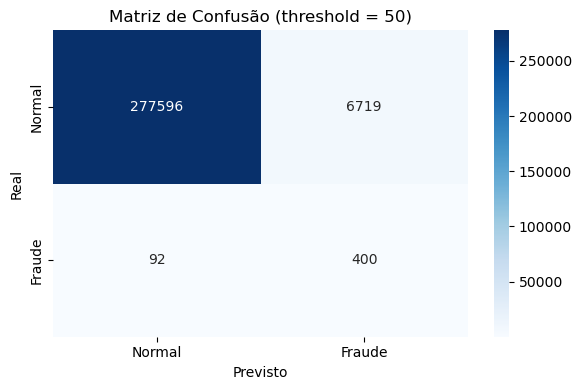

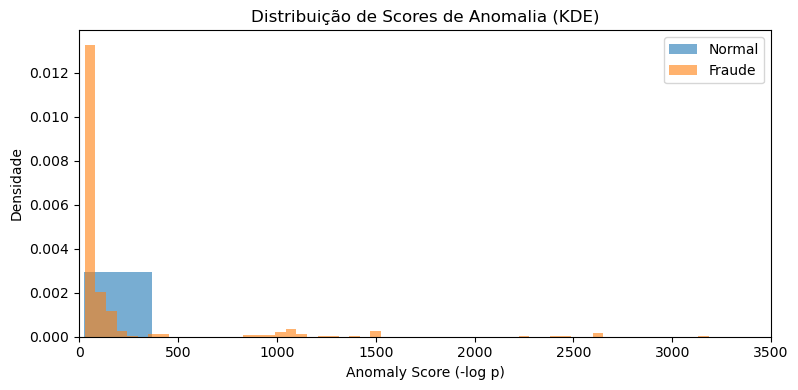

In [11]:
threshold = 50
y_pred = (df_scores['anomaly_score'] > threshold).astype(int)

# Avaliação
print(classification_report(df_scores['true_class'], y_pred))

# Matriz de confusão
cm = confusion_matrix(df_scores['true_class'], y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Fraude'],
            yticklabels=['Normal', 'Fraude'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão (threshold = {threshold})')
plt.tight_layout()
plt.show()



# 8. Plotar distribuições de anomaly_score
plt.figure(figsize=(8, 4))
plt.hist(anomalie_score[y == 0], bins=100, density=True, alpha=0.6, label='Normal')
plt.hist(anomalie_score[y == 1], bins=100, density=True, alpha=0.6, label='Fraude')
plt.title('Distribuição de Scores de Anomalia (KDE)')
plt.xlabel('Anomaly Score (-log p)')
plt.ylabel('Densidade')
plt.legend()
plt.tight_layout()
plt.xlim(0, 3500)
plt.show()

## Segunda abordagem

Score: -16371134.007275064; width: 0.5
Score: -14190707.465485357; width: 0.6
Score: -13118557.261895383; width: 0.7
Score: -12659384.68789026; width: 0.7999999999999999
Score: -12538496.39385165; width: 0.8999999999999999
Score: -12611605.34877429; width: 0.9999999999999999
Score: -12802387.719337182; width: 1.0999999999999999
Score: -13051053.653156804; width: 1.1999999999999997
Score: -13334941.633030433; width: 1.2999999999999998
Score: -13636114.0392097; width: 1.4
melhor banda: 0.8999999999999999


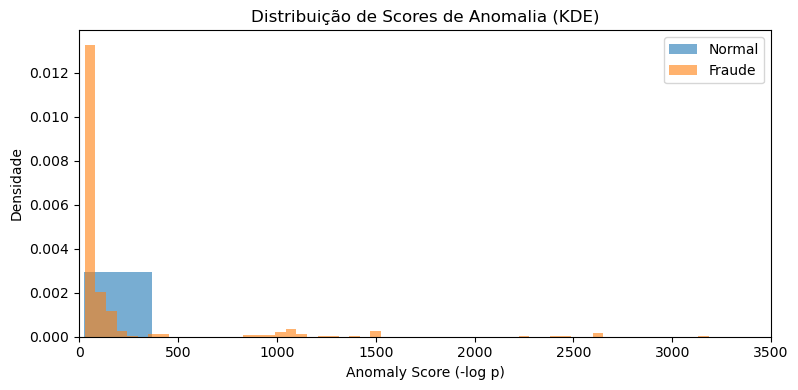

In [12]:
# Eu preciso dos dados sem classe
X = df.drop(columns=['Class'])
y = df['Class']

# Eu preciso dos dados normais
X_normal_sample = df[df['Class'] == 0].drop(columns=['Class']).sample(n=200, random_state=42)

## Agora eu preciso fazer o modelo entender quais são os dados normais

standard_scaler = StandardScaler()
X_normal_sampled_scaled = standard_scaler.fit_transform(X_normal_sample)
X_scaled = standard_scaler.transform(X)


# Treinar o KDE
best_bw, max_value = 0, -np.inf
for bw in np.arange(0.5,1.5, 0.1):
    kde = KernelDensity(bandwidth=bw, kernel='gaussian', algorithm='auto')
    kde.fit(X_normal_sampled_scaled)
    ##Calcular o score dos dados
    score = kde.score(X_scaled[y==0])
    print(f'Score: {score}; width: {bw}')
    if (score > max_value):
        max_value = score
        best_bw = bw
print(f'melhor banda: {best_bw}')


df_scores = pd.DataFrame(
    {
        'anomaly_score': anomalie_score,
        'true_class': y
    }
)

# 8. Plotar distribuições de anomaly_score
plt.figure(figsize=(8, 4))
plt.hist(anomalie_score[y == 0], bins=100, density=True, alpha=0.6, label='Normal')
plt.hist(anomalie_score[y == 1], bins=100, density=True, alpha=0.6, label='Fraude')
plt.title('Distribuição de Scores de Anomalia (KDE)')
plt.xlabel('Anomaly Score (-log p)')
plt.ylabel('Densidade')
plt.legend()
plt.tight_layout()
plt.xlim(0, 3500)
plt.show()